In [18]:
import pandas as pd
import numpy as np

In [19]:
data_path = "../data/raw/abalone.data"
features = ["sex", "length", "diameter", "height", "whole_weight", 
            "shucked_weight", "viscera_weight", "shell_weight", "rings"]
df = pd.read_csv(data_path, sep=",", names=features)


In [20]:
conditions = [
    df["rings"].between(0, 7),
    df["rings"].between(8, 10),
    df["rings"].between(11, 15),
    df["rings"] >15
]

choices = [1, 2, 3, 4]

df["age_class"] = np.select(conditions, choices)
df = df.drop("rings", axis=1)

In [21]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(df[["sex"]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["sex"]))
df = pd.concat([df.drop("sex", axis=1), encoded_df], axis=1)

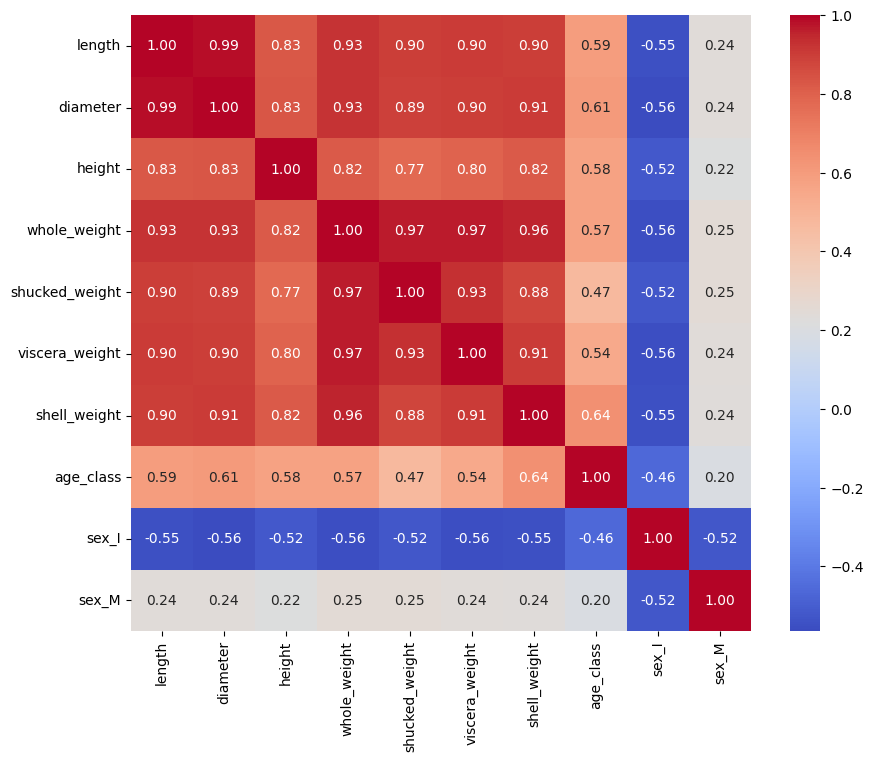

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


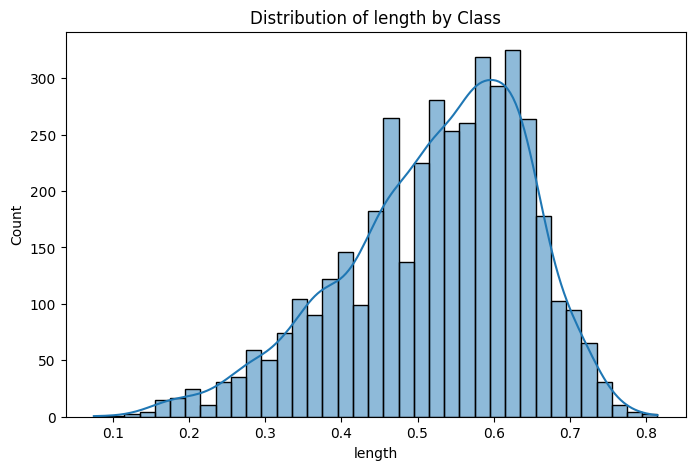

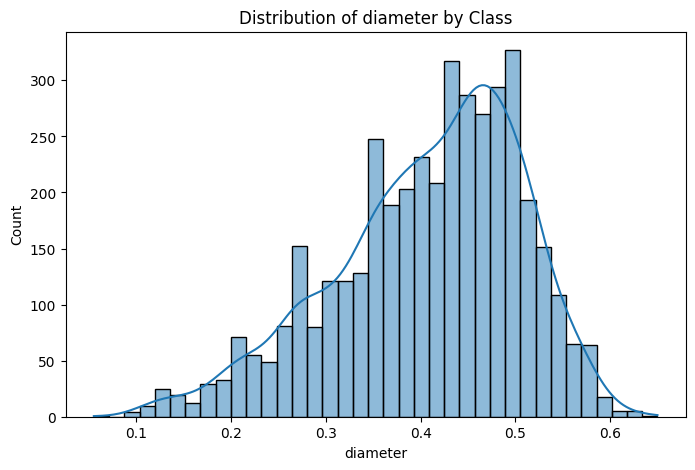

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

selected_features = ['length', 'diameter']

for feature in selected_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=feature, kde=True, multiple='stack')
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

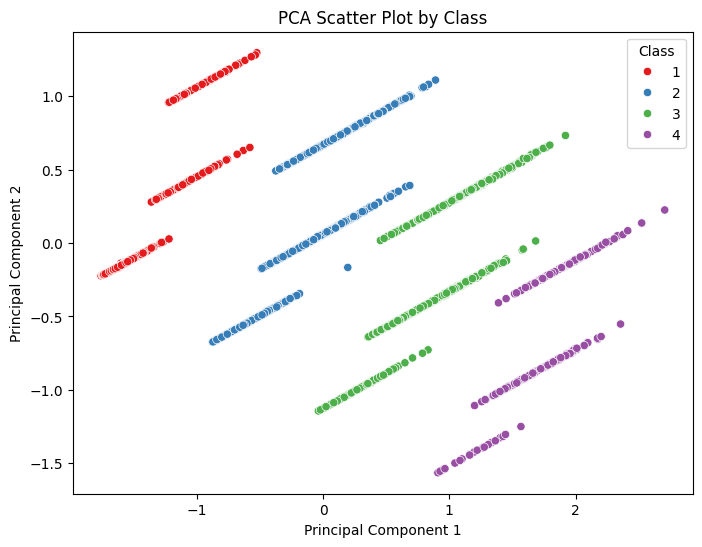

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
y = df["age_class"]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=y, palette='Set1')
plt.title('PCA Scatter Plot by Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class')
plt.show()


In [22]:
import pickle
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from src.config import RESULTS_DIR

with open(f"{RESULTS_DIR}/best_decision_tree.pkl", "rb") as f:
    best_dt = pickle.load(f)

tree_model = best_dt.model  

feature_names = [
    "Sex", "Length", "Diameter", "Height", "Whole_weight",
    "Shucked_weight", "Viscera_weight", "Shell_weight"
]  

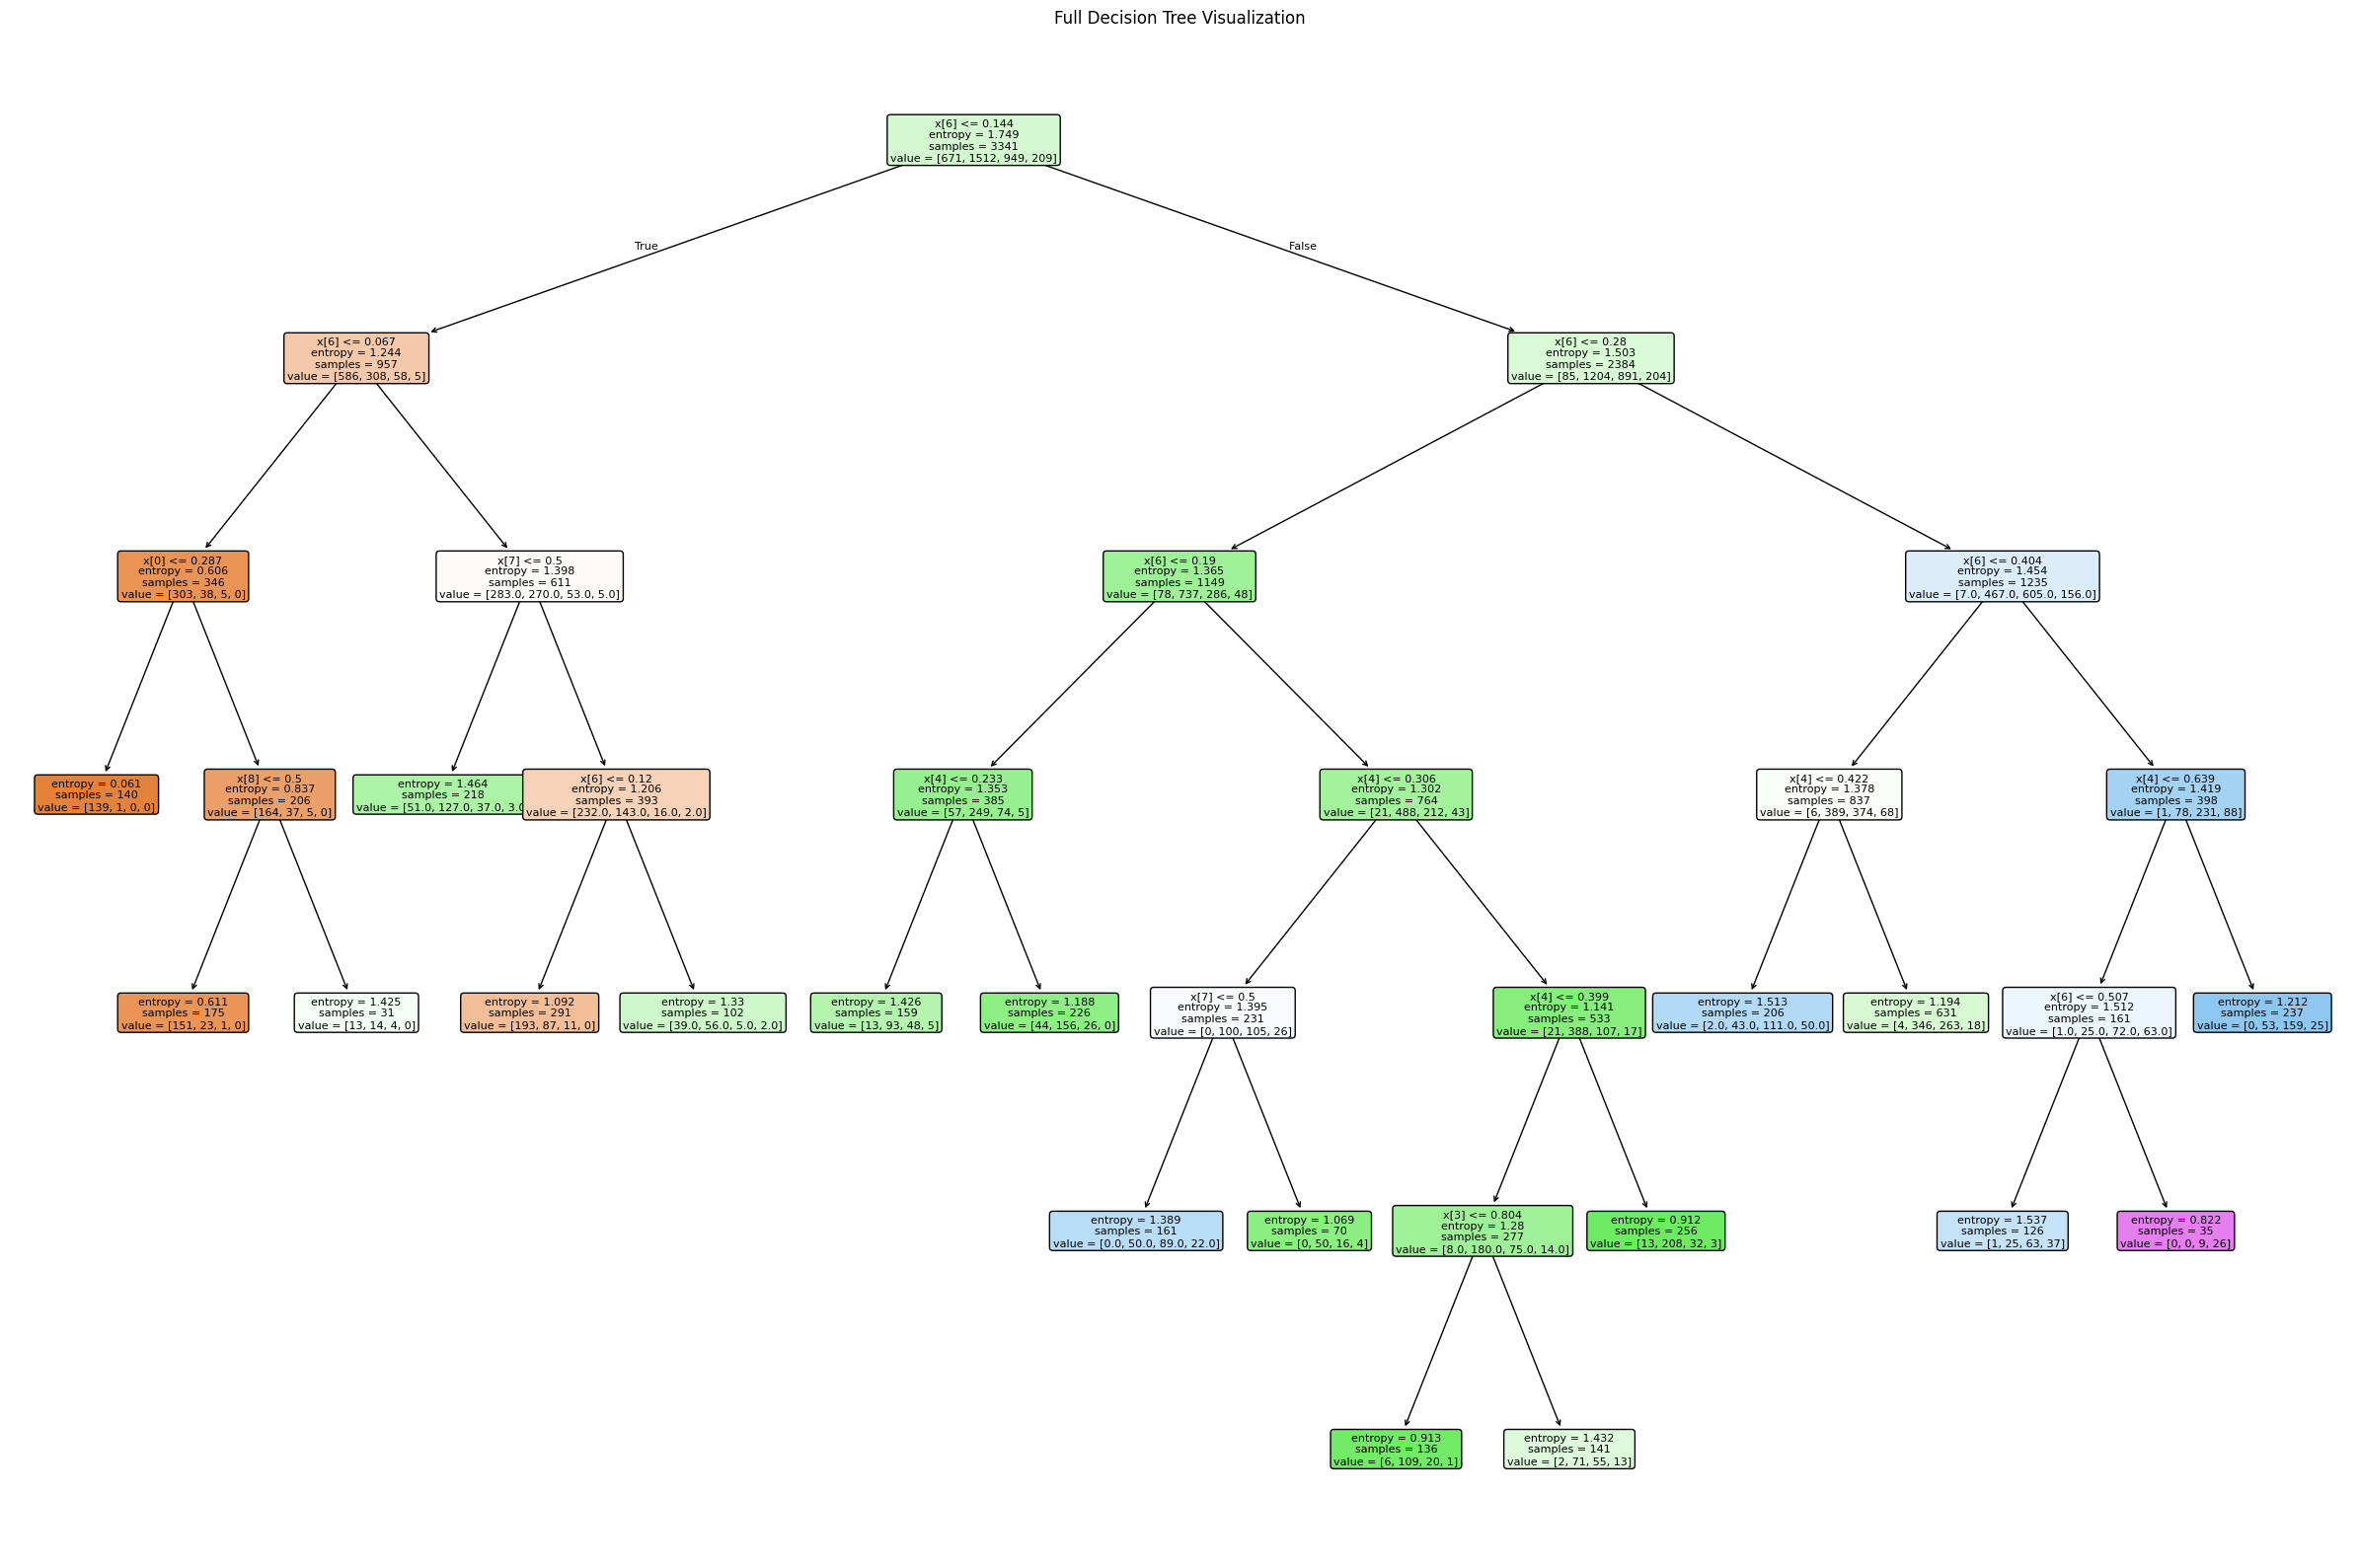

In [28]:
feature_names = [
    "Sex_I", "Sex_M",
    "Length", "Diameter", "Height", "Whole_weight",
    "Shucked_weight", "Viscera_weight", "Shell_weight"
]

class_names = ["Class 0", "Class 1", "Class 2", "Class 3"] 
plt.figure(figsize=(24, 16))
plot_tree(
    tree_model,
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=None  
)
plt.title("Full Decision Tree Visualization")
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/decision_tree_full.png", dpi=150, bbox_inches="tight")
plt.show()


In [29]:
tree_rules = export_text(
    tree_model,
    feature_names=feature_names,
    max_depth=3 
)
print("Decision Rules (Top 3 Levels):")
print(tree_rules)


Decision Rules (Top 3 Levels):
|--- Shucked_weight <= 0.14
|   |--- Shucked_weight <= 0.07
|   |   |--- Sex_I <= 0.29
|   |   |   |--- class: 0
|   |   |--- Sex_I >  0.29
|   |   |   |--- Shell_weight <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Shell_weight >  0.50
|   |   |   |   |--- class: 1
|   |--- Shucked_weight >  0.07
|   |   |--- Viscera_weight <= 0.50
|   |   |   |--- class: 1
|   |   |--- Viscera_weight >  0.50
|   |   |   |--- Shucked_weight <= 0.12
|   |   |   |   |--- class: 0
|   |   |   |--- Shucked_weight >  0.12
|   |   |   |   |--- class: 1
|--- Shucked_weight >  0.14
|   |--- Shucked_weight <= 0.28
|   |   |--- Shucked_weight <= 0.19
|   |   |   |--- Height <= 0.23
|   |   |   |   |--- class: 1
|   |   |   |--- Height >  0.23
|   |   |   |   |--- class: 1
|   |   |--- Shucked_weight >  0.19
|   |   |   |--- Height <= 0.31
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Height >  0.31
|   |   |   |   |--- truncated branch of depth 3
|   |

In [30]:
def extract_sample_rules(tree, feature_names, class_names, max_rules=5):
    tree_ = tree.tree_
    rules = []
    
    def recurse(node, path):
        if len(rules) >= max_rules:
            return
        
        if tree_.feature[node] == -2:
            class_idx = tree_.value[node].argmax()
            rule = "IF " + " AND ".join(path) + f" THEN {class_names[class_idx]}"
            rules.append(rule)
            return
        
        feat = feature_names[tree_.feature[node]]
        thresh = tree_.threshold[node]
        
        recurse(tree_.children_left[node], path + [f"{feat} <= {thresh:.2f}"])
        recurse(tree_.children_right[node], path + [f"{feat} > {thresh:.2f}"])
    
    recurse(0, [])
    return rules

sample_rules = extract_sample_rules(tree_model, feature_names, class_names, max_rules=5)

print("\nSample IF-THEN Rules:")
print("-" * 50)
for i, rule in enumerate(sample_rules, 1):
    print(f"{i}. {rule}")


Sample IF-THEN Rules:
--------------------------------------------------
1. IF Shucked_weight <= 0.14 AND Shucked_weight <= 0.07 AND Sex_I <= 0.29 THEN Class 0
2. IF Shucked_weight <= 0.14 AND Shucked_weight <= 0.07 AND Sex_I > 0.29 AND Shell_weight <= 0.50 THEN Class 0
3. IF Shucked_weight <= 0.14 AND Shucked_weight <= 0.07 AND Sex_I > 0.29 AND Shell_weight > 0.50 THEN Class 1
4. IF Shucked_weight <= 0.14 AND Shucked_weight > 0.07 AND Viscera_weight <= 0.50 THEN Class 1
5. IF Shucked_weight <= 0.14 AND Shucked_weight > 0.07 AND Viscera_weight > 0.50 AND Shucked_weight <= 0.12 THEN Class 0
